In [1]:
import os
import sys
import requests
from dotenv import load_dotenv
from typing import Dict, Any

print(sys.path)
print(os.getcwd())

load_dotenv("/Users/paddy/Documents/Github/Dump-Truck/clash-of-clans-agent/.env")

['/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python312.zip', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/lib-dynload', '', '/Users/paddy/Documents/Github/Dump-Truck/.venv/lib/python3.12/site-packages']
/Users/paddy/Documents/Github/Dump-Truck/clash-of-clans-agent


True

In [2]:
import os
from opentelemetry import trace as trace_api
from opentelemetry.sdk.trace.export import BatchSpanProcessor

from phoenix.otel import HTTPSpanExporter
from arize.otel import register as arize_register
from openinference.instrumentation.langchain import LangChainInstrumentor

PHOENIX_COLLECTOR = "https://app.phoenix.arize.com/s/padmanabhan-rajendra/v1/traces"
PHOENIX_API_KEY = os.environ.get("PHOENIX_API_KEY")

# 1) Arize tracer provider + its default exporter
tracer_provider = arize_register(
    space_id=os.environ["ARIZE_SPACE_ID"],
    api_key=os.environ["ARIZE_API_KEY"],
    project_name="my-langchain-app",
)

# 2) Add Phoenix exporter as an additional span processor
phoenix_exporter = HTTPSpanExporter(
    endpoint=PHOENIX_COLLECTOR,
    headers={"authorization": f"Bearer {PHOENIX_API_KEY}"},
)
phoenix_processor = BatchSpanProcessor(phoenix_exporter)

# Add the Phoenix processor to the existing tracer provider
tracer_provider.add_span_processor(phoenix_processor)

# If you ALSO want a local Phoenix target, you can add it:
local_exporter = HTTPSpanExporter(endpoint="http://127.0.0.1:6006/v1/traces")
local_processor = BatchSpanProcessor(local_exporter)
tracer_provider.add_span_processor(local_processor)

# 3) Set global + instrument LangChain
trace_api.set_tracer_provider(tracer_provider)
LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

print("LangChain instrumented → Arize + Phoenix (SaaS [+ local if enabled])")


Overriding of current TracerProvider is not allowed


🔭 OpenTelemetry Tracing Details 🔭
|  Arize Project: my-langchain-app
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: otlp.arize.com
|  Transport: gRPC
|  Transport Headers: {'authorization': '****', 'api_key': '****', 'arize-space-id': '****', 'space_id': '****', 'arize-interface': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

LangChain instrumented → Arize + Phoenix (SaaS [+ local if enabled])


In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

# from langchain_groq import ChatGroq
# llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

# from langchain_deepseek import ChatDeepSeek
# llm = ChatDeepSeek(
#     model="deepseek/deepseek-v3.2",
#     api_key=os.getenv("OPENROUTER_API_KEY"),
#     api_base="https://openrouter.ai/api/v1",
#     extra_body={"reasoning": {"enabled": True}},
# )

In [4]:
# Tool Functions
from typing import Dict, Any
import requests

BASE_URL = "https://api.clashofclans.com/v1"
TOKEN = os.getenv("CLASH_API_TOKEN")


def get_clan_details(clan_tag: str) -> Dict[str, Any]:
    """
    Fetch clan information by clan tag.
    
    Args:
        clan_tag (str): Clan tag (e.g., "#2YGRG9JCU")
    
    Returns:
        Dict[str, Any]: Clan information from the Clash of Clans API
    
    Raises:
        Exception: If API request fails (non-200 status code)
    """
    encoded_tag = clan_tag.replace("#", "%23")
    
    headers = {
        "Authorization": f"Bearer {TOKEN}",
        "Accept": "application/json"
    }
    
    response = requests.get(f"{BASE_URL}/clans/{encoded_tag}", headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"API Error {response.status_code}: {response.text}")
    
    return response.json()


def get_player_details(player_tag: str) -> Dict[str, Any]:
    """
    Fetch player information by player tag.
    
    Args:
        player_tag (str): Player tag (e.g., "#ABC123")
    
    Returns:
        Dict[str, Any]: Player information from the Clash of Clans API
    
    Raises:
        Exception: If API request fails (non-200 status code)
    """
    encoded_tag = player_tag.replace("#", "%23")
    
    headers = {
        "Authorization": f"Bearer {TOKEN}",
        "Accept": "application/json"
    }
    
    response = requests.get(f"{BASE_URL}/players/{encoded_tag}", headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"API Error {response.status_code}: {response.text}")
    
    return response.json()

In [5]:
tools = [get_clan_details, get_player_details]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=True)

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [7]:
CLASH_OF_CLANS_SYSTEM_PROMPT = """
You are a Clash of Clans assistant who helps users with their queries 
about clans and players.

You have access to two tools:
- get_clan_details
- get_player_details

Guidelines:
- Users will generally query based on clan tags or player tags.
- Always choose the correct tool based on what the user is asking for.
- After calling a tool, analyze the returned information and answer 
  the user’s query as accurately and clearly as possible.
"""

sys_msg = SystemMessage(content=CLASH_OF_CLANS_SYSTEM_PROMPT)

In [8]:
def coc_assistant(state: MessagesState):
    return {
        "messages": [
            llm_with_tools.invoke([sys_msg] + state["messages"])
        ]
    }


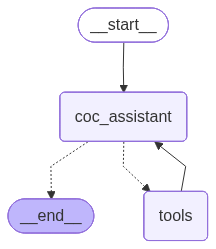

In [9]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("coc_assistant", coc_assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "coc_assistant")

builder.add_conditional_edges(
    "coc_assistant",
    tools_condition,
)

builder.add_edge("tools", "coc_assistant")


coc_graph = builder.compile()
display(Image(coc_graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
messages = [HumanMessage(content="Fetch the details of the player with tag #LPOG2R8Y")]
messages = coc_graph.invoke({"messages": messages})

In [13]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Fetch the details of the player with tag #LPOG2R8Y
================================== Ai Message ==================================
Tool Calls:
  get_player_details (90da08cb-a5e0-461e-b89e-f8acbb8749fb)
 Call ID: 90da08cb-a5e0-461e-b89e-f8acbb8749fb
  Args:
    player_tag: #LPOG2R8Y
================================= Tool Message =================================
Name: get_player_details

{"tag": "#LP0G2R8Y", "name": "warrior KN", "townHallLevel": 14, "townHallWeaponLevel": 1, "expLevel": 188, "trophies": 0, "bestTrophies": 3518, "warStars": 218, "attackWins": 0, "defenseWins": 0, "builderHallLevel": 10, "builderBaseTrophies": 3507, "bestBuilderBaseTrophies": 3939, "donations": 0, "donationsReceived": 0, "clanCapitalContributions": 489219, "leagueTier": {"id": 105000014, "name": "Valkyrie League 14", "iconUrls": {"small": "https://api-assets.clashofclans.com/leaguetiers/125/7AbbZbiV6whmfa6CZtqt6Ml4NgFH1B-